In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties as unc
plt.style.use('belle2')
#%jsroot on

#%run functins.ipynb

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0mumupip4Streams.root"
#file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip200000.root"

file_rec_jpsi="/pnfs/desy.de/belle/local/user/msobotzi/jpsi/afterAcceptance/B0mumupip.root"
file_gen_jpsi="/pnfs/desy.de/belle/local/user/msobotzi/jpsi/afterPreCals/MC511_pip.root"


In [3]:
import uproot
import pandas as pd

def process_MC_data_combined(file_path, ll, particle_name, q2):
    def process_mc_data(file_path):
        df = uproot.open(f"{file_path}:rec511")
        mc_data = df.arrays(library='pd')
        mc_cut = mc_data.query('NNPass==1')
        mc_cut_np_bc = mc_cut.query('bestCandidate == 1')
        return mc_cut_np_bc
    
    df_bkg_particle_name = process_mc_data(file_path)
    
    if q2 == 11:
        df_bkg_particle_name_q2cut = df_bkg_particle_name.query(f"q2reg == {q2}")

        if ll == 'ee':
            cut = (
                "l1_genMotherPDG == 443 and Kst_isSignal== 1 and l1_genMotherPDG_1 == Kst_genMotherPDG and "
                "abs(Kst_genMotherPDG)==511 and abs(Kst_pi_mcPDG) == 211 and abs(Kst_K_isSignal) == 1 and abs(l1_mcPDG) == 11"
            )
        elif ll == 'mumu':
            cut = (
                "l1_genMotherPDG == 443 and Kst_isSignal== 1 and l1_genMotherPDG_1 == Kst_genMotherPDG and "
                "abs(Kst_genMotherPDG)==511 and abs(Kst_pi_mcPDG) == 211 and abs(Kst_K_isSignal) == 1 and abs(l1_mcPDG) == 13"
            )
        else:
            raise ValueError(f"Unknown ll: {ll}")

        deltaE_range = (-0.15, 0.15)

        mc_particle_name_signal_jpsi = df_bkg_particle_name_q2cut.query(
            f"{cut} and deltaE >= {deltaE_range[0]} and deltaE <= {deltaE_range[1]}"
        )

        mc_particle_name_bkg_jpsi = df_bkg_particle_name_q2cut.query(
            f'not ({cut}) and deltaE >= {deltaE_range[0]} and deltaE <= {deltaE_range[1]}'
        )
        mc_particle_name_Continuum_bkg_jpsi = mc_particle_name_bkg_jpsi.query('isContinuumEvent==1')
        mc_particle_name_Bmeson_bkg_jpsi = mc_particle_name_bkg_jpsi.query('isContinuumEvent!=1')

        mc_signal_weight = mc_particle_name_signal_jpsi["PIDCorrectionAndAcceptanceWeight"]
        mc_Continuum_bkg_weight = mc_particle_name_Continuum_bkg_jpsi["PIDCorrectionAndAcceptanceWeight"]
        mc_Bmeson_bkg_weight = mc_particle_name_Bmeson_bkg_jpsi["PIDCorrectionAndAcceptanceWeight"]
        
        return (
            mc_particle_name_signal_jpsi,
            mc_particle_name_Continuum_bkg_jpsi,
            mc_particle_name_Bmeson_bkg_jpsi,
            mc_signal_weight,
            mc_Continuum_bkg_weight,
            mc_Bmeson_bkg_weight
        )
    else:
        raise ValueError(f"Unknown q2: {q2}")

mc_mu_signal, mc_mu_Continuum_bkg, mc_mu_Bmeson_bkg, mc_mu_signal_weight, mc_mu_Continuum_bkg_weight, mc_mu_Bmeson_bkg_weight = process_MC_data_combined(file_bkg, 'mumu', 'mu', 11)

mc_mu_bkg_weight = pd.concat([mc_mu_Bmeson_bkg_weight, mc_mu_Continuum_bkg_weight])
weights = mc_mu_signal_weight.sum()
weights_bkg = mc_mu_bkg_weight.sum()
print(weights)
print(weights_bkg)


70299.47938268282
27182.227568410955


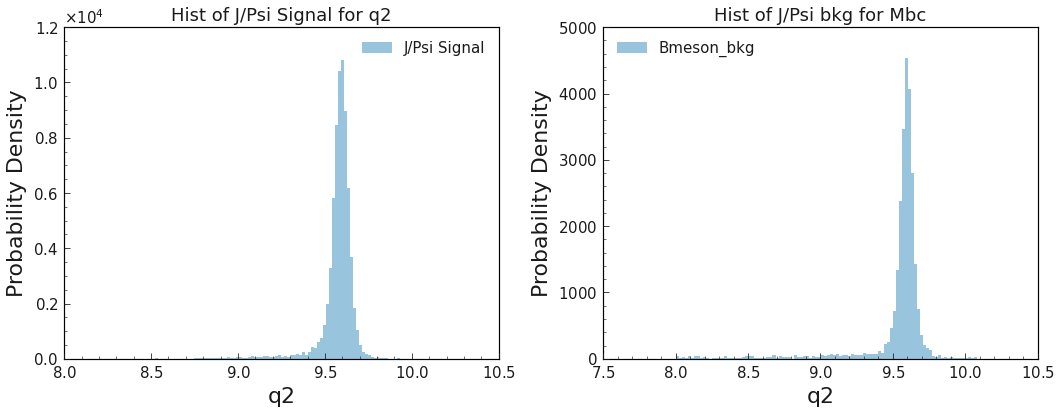

In [4]:
def plot_histogram(ax, data_dict, labels, data_weight, xlabel, ylabel, title):
    for label in labels:
        ax.hist(data_dict[label], weights=data_weight[label], bins=100, alpha=0.5, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.set_title(title)


# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))


# q2_signal
plot_histogram(axs[0], {"J/Psi Signal": mc_mu_signal["q2"]}, ["J/Psi Signal"],
               {"J/Psi Signal": mc_mu_signal_weight}, 'q2', 'Probability Density', 'Hist of J/Psi Signal for q2')

'''
# Mbc_signal
plot_histogram(axs[0, 0], {"J/Psi Signal": mc_mu_signal["Mbc"]}, ["J/Psi Signal"],
               {"J/Psi Signal": mc_mu_signal_weight}, 'Mbc', 'Probability Density', 'Hist of J/Psi Signal for Mbc')

# Mbc_bkg
plot_histogram(axs[1, 0], {"Continuum_bkg": mc_mu_Continuum_bkg_data["Mbc"],
                           "Bmeson_bkg": mc_mu_Bmeson_bkg_data["Mbc"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_mu_Continuum_bkg_weight, "Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of J/Psi bkg for Mbc')

# q2_bkg
plot_histogram(axs[1, 1], {"Continuum_bkg": mc_mu_Continuum_bkg_data["q2"],
                           "Bmeson_bkg": mc_mu_Bmeson_bkg_data["q2"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_mu_Continuum_bkg_weight, "Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'q2', 'Probability Density', 'Hist of J/Psi bkg for Mbc')

# Mbc_bkg
plot_histogram(axs[1, 0], {"Bmeson_bkg": mc_mu_Bmeson_bkg["Mbc"]},
               ["Bmeson_bkg"],
               {"Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of J/Psi bkg for Mbc')
'''
# q2_bkg
plot_histogram(axs[1], {
                           "Bmeson_bkg": mc_mu_Bmeson_bkg["q2"]},
               ["Bmeson_bkg"],
               {"Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'q2', 'Probability Density', 'Hist of J/Psi bkg for Mbc')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [5]:
df_gen = uproot.open(f"{file_gen_jpsi}:rec511")
df_rec = uproot.open(f"{file_rec_jpsi}:rec511")
df_bkg = uproot.open(f"{file_bkg}:rec511")

df_gen_mu = df_gen.arrays(library='pd')
df_rec_mu = df_rec.arrays(library='pd')
df_bkg_mu = df_bkg.arrays(library='pd')


cut = "l1_genMotherPDG == 443 and Kst_isSignal== 1 and l1_genMotherPDG_1 == Kst_genMotherPDG and abs(Kst_genMotherPDG)==511 and abs(Kst_pi_mcPDG) == 211 and abs(Kst_K_isSignal) == 1 and abs(l1_mcPDG) == 13"
cutRec = cut + " and NNPass == 1 and bestCandidate == 1"


# Apply the `cut` to `df_gen_mu`
df_gen_mu = df_gen_mu.query(cut)

# Apply the `cutRec` to `df_rec_mu` and `df_bkg_mu`
mc_df_rec_mu = df_rec_mu.query(cutRec)
mc_df_bkg_mu = df_bkg_mu.query(cutRec)

df_bkg_mu_weights = mc_df_bkg_mu['PIDCorrectionAndAcceptanceWeight'].sum()

# Print the lengths of the dataframes
#print(len(df_gen_mu))
#print(len(df_rec_mu))
#print(len(df_bkg_mu))

print(df_bkg_mu_weights)



71896.1028870735


In [6]:
efficiency = df_rec_mu['weights'].sum()/len(df_gen_mu)
print(efficiency)

0.2680891069120886


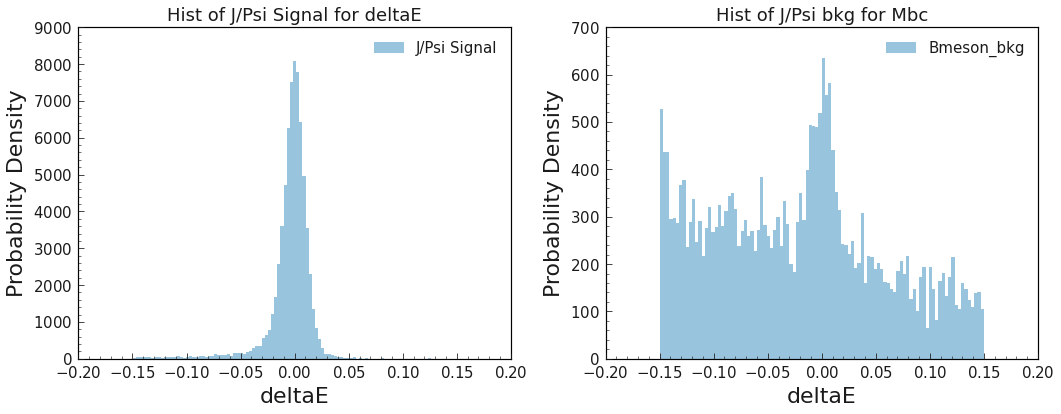

In [7]:
def plot_histogram(ax, data_dict, labels, data_weight, xlabel, ylabel, title):
    for label in labels:
        ax.hist(data_dict[label], weights=data_weight[label], bins=100, alpha=0.5, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.set_title(title)


# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))


# deltaE_signal
plot_histogram(axs[0], {"J/Psi Signal": mc_mu_signal["deltaE"]}, ["J/Psi Signal"],
               {"J/Psi Signal": mc_mu_signal_weight}, 'deltaE', 'Probability Density', 'Hist of J/Psi Signal for deltaE')

'''
# Mbc_signal
plot_histogram(axs[0, 0], {"J/Psi Signal": mc_mu_signal["Mbc"]}, ["J/Psi Signal"],
               {"J/Psi Signal": mc_mu_signal_weight}, 'Mbc', 'Probability Density', 'Hist of J/Psi Signal for Mbc')

# Mbc_bkg
plot_histogram(axs[1, 0], {"Continuum_bkg": mc_mu_Continuum_bkg_data["Mbc"],
                           "Bmeson_bkg": mc_mu_Bmeson_bkg_data["Mbc"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_mu_Continuum_bkg_weight, "Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of J/Psi bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[1, 1], {"Continuum_bkg": mc_mu_Continuum_bkg_data["deltaE"],
                           "Bmeson_bkg": mc_mu_Bmeson_bkg_data["deltaE"]},
               ["Continuum_bkg", "Bmeson_bkg"],
               {"Continuum_bkg": mc_mu_Continuum_bkg_weight, "Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of J/Psi bkg for Mbc')

# Mbc_bkg
plot_histogram(axs[1, 0], {"Bmeson_bkg": mc_mu_Bmeson_bkg["Mbc"]},
               ["Bmeson_bkg"],
               {"Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of J/Psi bkg for Mbc')
'''
# deltaE_bkg
plot_histogram(axs[1], {
                           "Bmeson_bkg": mc_mu_Bmeson_bkg["deltaE"]},
               ["Bmeson_bkg"],
               {"Bmeson_bkg": mc_mu_Bmeson_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of J/Psi bkg for Mbc')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [8]:
def fit(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    ratios_label_dataset_model_type = None
        

    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", 5.279)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.005)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 4)
        
        
        label_dataset_name_model_type = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    
    elif model_type == 'cb_gauss':
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", -0.0)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.09)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 2)

        label_dataset_name_cb = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", -0.0)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.096)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb, label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.29, 5.28, 5.3)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-50)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", 5.278)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.005)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus,label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly, label_dataset_name_argus],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
        
    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_ele_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_ele_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_ele_label_dataset_name_poly, coeff1_ele_label_dataset_name_poly])

        # Gaussian
        mu_ele_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.0)
        sigma_ele_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.08)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_ele_label_dataset_name_gauss, sigma=sigma_ele_label_dataset_name_gauss)
        
        # Fraction
        frac_ele_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly,label_dataset_name_gauss],
            fracs=[frac_ele_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_model_type = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_model_type = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    
    data_label_dataset_name = zfit.data.Data.from_pandas(
    mc_dataset_name_data_label,
    obs=obs_label,
    weights=mc_dataset_name_weight_label
    )
   
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
    
    # Extract and save the parameter values
    parameters_values = {
        "_".join(param.name.split('_')[:-1]): param.numpy() for param in label_dataset_name_model_type.get_params()
    }
    ratios_label_dataset_model_type = pd.DataFrame(parameters_values, index=[0])
    ratios_label_dataset_model_type.to_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}.csv", index=False)
    
    return label_dataset_name_model_type, result_label_dataset_name


#Signal
Mbc_mu_signal_cb,result_Mbc_mu_signal = fit('Mbc', 'mu', 'signal', mc_mu_signal["Mbc"],mc_mu_signal_weight,'cb')
deltaE_mu_signal_cb_gauss,result_deltaE_mu_signal = fit('deltaE', 'mu', 'signal', mc_mu_signal["deltaE"],mc_mu_signal_weight, 'cb_gauss')

#Bmeson_bkg
Mbc_mu_Bmeson_bkg_poly_argus,result_Mbc_mu_Bmeson_bkg = fit('Mbc', 'mu', 'Bmeson_bkg', mc_mu_Bmeson_bkg["Mbc"],mc_mu_Bmeson_bkg_weight, 'argus_gauss')
deltaE_mu_Bmeson_bkg_poly_gauss,result_deltaE_mu_Bmeson_bkg  = fit('deltaE', 'mu', 'Bmeson_bkg', mc_mu_Bmeson_bkg["deltaE"],mc_mu_Bmeson_bkg_weight, 'poly_gauss')

#Continuum_bkg
Mbc_mu_Continuum_bkg_poly,result_Mbc_mu_Continuum_bkg = fit('Mbc','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["Mbc"],mc_mu_Continuum_bkg_weight,'poly')
deltaE_mu_Continuum_bkg_poly_gauss,result_deltaE_mu_Continuum_bkg  = fit('deltaE','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["deltaE"],mc_mu_Continuum_bkg_weight,'poly_gauss')


In [9]:
def plot_with_fit(ax,bins, data, data_weight, fitted_model, data_range, label_data, label_fit, xlabel, ylabel, title):
    # Calculate histogram
    n, bins, _ = ax.hist(data, bins=bins, weights=data_weight, density=False, alpha=0.5, label=label_data)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((data >= bins[i]) & (data < bins[i+1]))[0]
        bin_weights.append(data_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # De-normalization
    pdf_values = fitted_model.pdf(data_range).numpy() * sum(data_weight) * (bins[1] - bins[0])

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
    ax.plot(data_range, pdf_values, 'r', label=label_fit)

    # Add labels and title
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_title(title, fontsize=15)
    return pdf_values

name                             value  (rounded)    at limit
-----------------------------  ------------------  ----------
mu_mu_Mbc_signal_cb_0.4804                5.27963       False
sigma_mu_Mbc_signal_cb_0.4804          0.00281302       False
alpha_mu_Mbc_signal_cb_0.4804             2.82232       False
n_mu_Mbc_signal_cb_0.4804                 3.13953       False
True
name                                     value  (rounded)    at limit
-------------------------------------  ------------------  ----------
frac_mu_deltaE_signal_cb_gauss_0.6671            0.971638       False
mu_mu_deltaE_signal_cb_0.6671                -0.000189187       False
sigma_mu_deltaE_signal_cb_0.6671               0.00954493       False
alpha_mu_deltaE_signal_cb_0.6671                  1.73147       False
n_mu_deltaE_signal_cb_0.6671                      1.41569       False
mu_mu_deltaE_signal_gauss_0.6671                0.0088335       False
sigma_mu_deltaE_signal_gauss_0.6671             0.0350567      

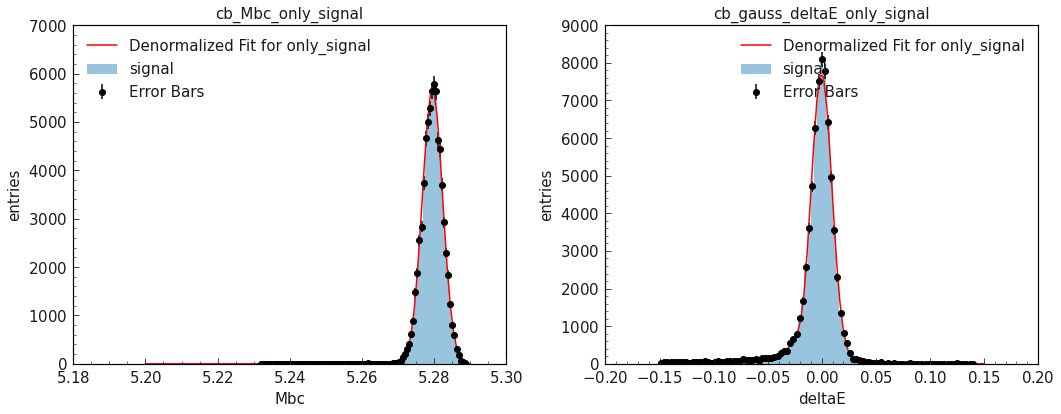

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)

fit_model_Mbc_only_signal = plot_with_fit(axs[0],100, mc_mu_signal["Mbc"], mc_mu_signal_weight, 
                                           Mbc_mu_signal_cb, Mbc_range, 
                                           'signal', 'Denormalized Fit for only_signal', 
                                           'Mbc', 'entries', 'cb_Mbc_only_signal')

fit_model_deltaE_only_signal = plot_with_fit(axs[1],100, mc_mu_signal["deltaE"], mc_mu_signal_weight, 
                                             deltaE_mu_signal_cb_gauss, deltaE_range, 
                                             'signal', 'Denormalized Fit for only_signal', 
                                             'deltaE', 'entries', 'cb_gauss_deltaE_only_signal')

# Adjust layout
plt.tight_layout()

# Print results if needed
print(result_Mbc_mu_signal.params)
print(result_Mbc_mu_signal.valid)
print(result_deltaE_mu_signal.params)
print(result_deltaE_mu_signal.valid)


# Show the plots
plt.show()

name                                         value  (rounded)    at limit
-----------------------------------------  ------------------  ----------
frac_mu_Mbc_Bmeson_bkg_argus_gauss_0.5699            0.779312       False
m_mu_Mbc_Bmeson_bkg_argus_0.5699                      5.28873       False
c_mu_Mbc_Bmeson_bkg_argus_0.5699                     -121.586       False
p_mu_Mbc_Bmeson_bkg_argus_0.5699                     0.543741       False
mu_mu_Mbc_Bmeson_bkg_gauss_0.5699                     5.27968       False
sigma_mu_Mbc_Bmeson_bkg_gauss_0.5699               0.00345648       False
True
name                                           value  (rounded)    at limit
-------------------------------------------  ------------------  ----------
frac_mu_deltaE_Bmeson_bkg_poly_gauss_0.8147             0.88119       False
coeff0_mu_deltaE_Bmeson_bkg_poly_0.8147                -0.49868       False
coeff1_mu_deltaE_Bmeson_bkg_poly_0.8147               0.0306253       False
mu_mu_deltaE_Bmeson_bkg

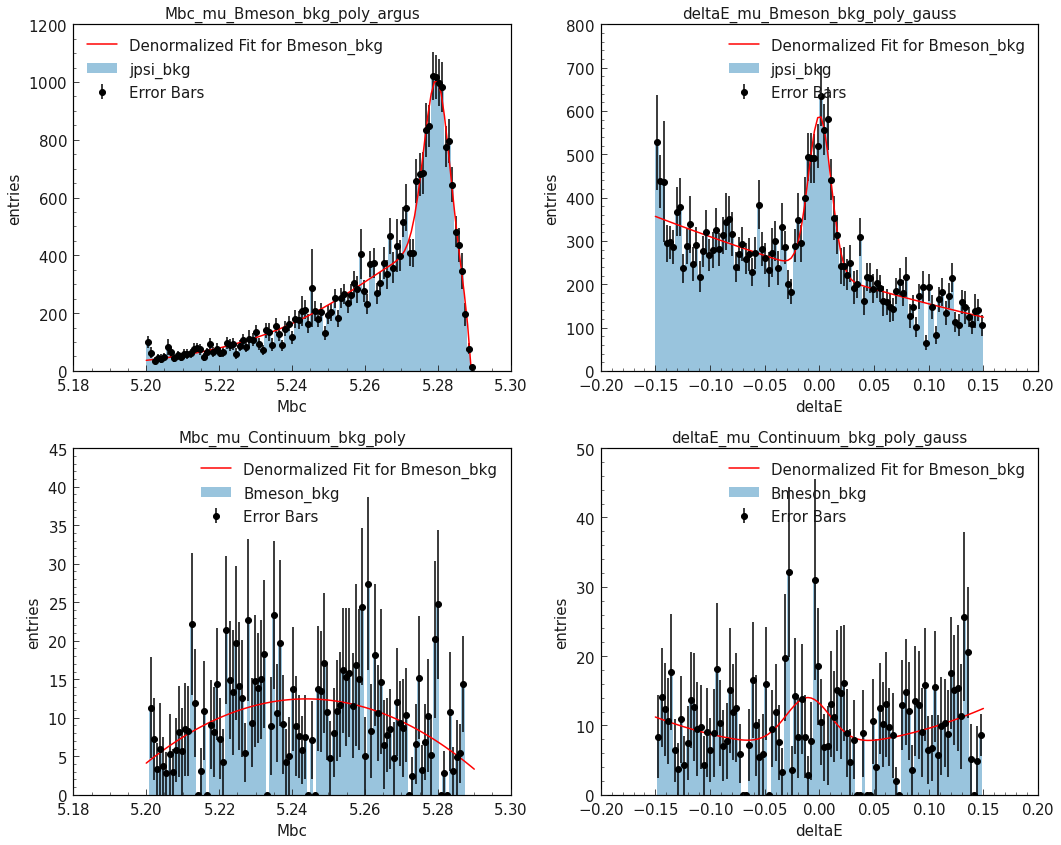

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)



fit_model_Mbc_jpsi_Bmeson_bkg = plot_with_fit(axs[0,0],100, mc_mu_Bmeson_bkg["Mbc"],mc_mu_Bmeson_bkg_weight, 
                                           Mbc_mu_Bmeson_bkg_poly_argus, Mbc_range, 
                                           'jpsi_bkg', 'Denormalized Fit for Bmeson_bkg', 
                                           'Mbc', 'entries', 'Mbc_mu_Bmeson_bkg_poly_argus')


fit_model_deltaE_jpsi_Bmeson_bkg = plot_with_fit(axs[0,1],100, mc_mu_Bmeson_bkg["deltaE"], mc_mu_Bmeson_bkg_weight, 
                                             deltaE_mu_Bmeson_bkg_poly_gauss, deltaE_range, 
                                             'jpsi_bkg', 'Denormalized Fit for Bmeson_bkg', 
                                             'deltaE', 'entries', 'deltaE_mu_Bmeson_bkg_poly_gauss')

fit_model_Mbc_jpsi_Continuum_bkg = plot_with_fit(axs[1,0],100, mc_mu_Continuum_bkg["Mbc"], mc_mu_Continuum_bkg_weight, 
                                           Mbc_mu_Continuum_bkg_poly, Mbc_range, 
                                           'Bmeson_bkg', 'Denormalized Fit for Bmeson_bkg', 
                                           'Mbc', 'entries', 'Mbc_mu_Continuum_bkg_poly')

# Plot for deltaE
fit_model_deltaE_jpsi_Continuum_bkg = plot_with_fit(axs[1,1],100, mc_mu_Continuum_bkg["deltaE"], mc_mu_Continuum_bkg_weight,
                                             deltaE_mu_Continuum_bkg_poly_gauss, deltaE_range, 
                                             'Bmeson_bkg', 'Denormalized Fit for Bmeson_bkg', 
                                             'deltaE', 'entries', 'deltaE_mu_Continuum_bkg_poly_gauss')


# Adjust layout
plt.tight_layout()


# Print results if needed

print(result_Mbc_mu_Bmeson_bkg.params)
print(result_Mbc_mu_Bmeson_bkg.valid)
print(result_deltaE_mu_Bmeson_bkg.params)
print(result_deltaE_mu_Bmeson_bkg.valid)
print(result_Mbc_mu_Continuum_bkg.params)
print(result_Mbc_mu_Continuum_bkg.valid)
print(result_deltaE_mu_Continuum_bkg.params)
print(result_deltaE_mu_Continuum_bkg.valid)

# Show the plots
plt.show()



## fixed fit

In [18]:
def fit_fixed(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    
    parameter_df = pd.read_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}.csv")
    
    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", 5.279)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
      
        label_dataset_name_model_type_fixed = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    elif model_type == 'cb_gauss':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"alpha_{particle_type}_{label}_{dataset_name}_cb"], floating=False)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", parameter_df[f"n_{particle_type}_{label}_{dataset_name}_cb"], floating=False)

        label_dataset_name_cb_fixed = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",0.5)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb_fixed, label_dataset_name_gauss_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)

    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f"coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}", parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",0.5)
        
        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed,label_dataset_name_gauss_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)

    
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"mu_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", parameter_df[f"sigma_{particle_type}_{label}_{dataset_name}_gauss"], floating=False)

        label_dataset_name_gauss_fixed = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus_fixed,label_dataset_name_gauss_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
  
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"], floating=False)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"], floating=False)

        label_dataset_name_poly_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"m_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"], floating=False)

        label_dataset_name_argus_fixed = zphysics.pdf.Argus(obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type_fixed = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly_fixed, label_dataset_name_argus_fixed],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label
        )
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.28819 )
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"c_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)
        p_particle_type_label_dataset_name_argus = zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", parameter_df[f"p_{particle_type}_{label}_{dataset_name}_argus"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
    
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff0_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=True)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', parameter_df[f"coeff1_{particle_type}_{label}_{dataset_name}_poly"].values[0], floating=False)

        label_dataset_name_model_type_fixed = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        

        
        
    data_label_dataset_name = zfit.data.Data.from_pandas(mc_label_particle_type_dataset_name_data, obs=obs_label, weights=mc_label_particle_type_dataset_name_weight)
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type_fixed, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
    
    return label_dataset_name_model_type_fixed, result_label_dataset_name
  
#Signal
Mbc_mu_signal_cb_fixed,result_Mbc_mu_signal_fixed = fit_fixed('Mbc', 'mu', 'signal', mc_mu_signal["Mbc"],mc_mu_signal_weight,'cb')
deltaE_mu_signal_cb_gauss_fixed,result_deltaE_mu_signal_fixed = fit_fixed('deltaE', 'mu', 'signal', mc_mu_signal["deltaE"],mc_mu_signal_weight, 'cb_gauss')

#Bmeson_bkg
Mbc_mu_Bmeson_bkg_poly_argus_fixed,result_Mbc_mu_Bmeson_bkg_fixed = fit_fixed('Mbc', 'mu', 'Bmeson_bkg', mc_mu_Bmeson_bkg["Mbc"],mc_mu_Bmeson_bkg_weight, 'argus_gauss')
deltaE_mu_Bmeson_bkg_poly_gauss_fixed,result_deltaE_mu_Bmeson_bkg_fixed  = fit_fixed('deltaE', 'mu', 'Bmeson_bkg', mc_mu_Bmeson_bkg["deltaE"],mc_mu_Bmeson_bkg_weight, 'poly_gauss')

#Continuum_bkg
Mbc_mu_Continuum_bkg_poly_fixed,result_Mbc_mu_Continuum_bkg_fixed = fit_fixed('Mbc','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["Mbc"],mc_mu_Continuum_bkg_weight,'poly')
deltaE_mu_Continuum_bkg_poly_fixed,result_deltaE_mu_Continuum_bkg_fixed  = fit_fixed('deltaE','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["deltaE"],mc_mu_Continuum_bkg_weight,'poly')
 
print(result_Mbc_mu_signal_fixed.params)
print(result_Mbc_mu_signal_fixed.valid)
print(result_deltaE_mu_signal_fixed.params)
print(result_deltaE_mu_signal_fixed.valid)
print(result_Mbc_mu_Bmeson_bkg_fixed.params)
print(result_Mbc_mu_Bmeson_bkg_fixed.valid)
print(result_deltaE_mu_Bmeson_bkg_fixed.params)
print(result_deltaE_mu_Bmeson_bkg_fixed.valid)
print(result_Mbc_mu_Continuum_bkg_fixed.params)
print(result_Mbc_mu_Continuum_bkg_fixed.valid)
print(result_deltaE_mu_Continuum_bkg_fixed.params)
print(result_deltaE_mu_Continuum_bkg_fixed.valid)

''' 
    return label_dataset_name_model_type_fixed

 
#Signal
Mbc_mu_signal_cb_fixed= fit_fixed('Mbc', 'mu', 'signal', mc_mu_signal["Mbc"],mc_mu_signal_weight,'cb')
deltaE_mu_signal_cb_gauss_fixed= fit_fixed('deltaE', 'mu', 'signal', mc_mu_signal["deltaE"],mc_mu_signal_weight, 'cb_gauss')

#Bmeson_bkg
Mbc_mu_Bmeson_bkg_poly_argus_fixed= fit_fixed('Mbc', 'mu', 'Bmeson_bkg', mc_mu_Bmeson_bkg["Mbc"],mc_mu_Bmeson_bkg_weight, 'argus_gauss')
deltaE_mu_Bmeson_bkg_poly_gauss_fixed= fit_fixed('deltaE', 'mu', 'Bmeson_bkg', mc_mu_Bmeson_bkg["deltaE"],mc_mu_Bmeson_bkg_weight, 'poly_gauss')

#Continuum_bkg
Mbc_mu_Continuum_bkg_poly_fixed= fit_fixed('Mbc','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["Mbc"],mc_mu_Continuum_bkg_weight,'poly')
deltaE_mu_Continuum_bkg_poly_fixed = fit_fixed('deltaE','mu', 'Continuum_bkg',  mc_mu_Continuum_bkg["deltaE"],mc_mu_Continuum_bkg_weight,'poly_gauss')

''' 
  


name                          value  (rounded)    at limit
--------------------------  ------------------  ----------
mu_mu_Mbc_signal_cb_0.8086             5.27963       False
True
name                                     value  (rounded)    at limit
-------------------------------------  ------------------  ----------
frac_mu_deltaE_signal_cb_gauss_0.4481            0.971648       False
True
name                                         value  (rounded)    at limit
-----------------------------------------  ------------------  ----------
frac_mu_Mbc_Bmeson_bkg_argus_gauss_0.4256            0.779311       False
True
name                                           value  (rounded)    at limit
-------------------------------------------  ------------------  ----------
frac_mu_deltaE_Bmeson_bkg_poly_gauss_0.4148            0.881198       False
True
name                                       value  (rounded)    at limit
---------------------------------------  ------------------  ----------

' \n    return label_dataset_name_model_type_fixed\n\n \n#Signal\nMbc_mu_signal_cb_fixed= fit_fixed(\'Mbc\', \'mu\', \'signal\', mc_mu_signal["Mbc"],mc_mu_signal_weight,\'cb\')\ndeltaE_mu_signal_cb_gauss_fixed= fit_fixed(\'deltaE\', \'mu\', \'signal\', mc_mu_signal["deltaE"],mc_mu_signal_weight, \'cb_gauss\')\n\n#Bmeson_bkg\nMbc_mu_Bmeson_bkg_poly_argus_fixed= fit_fixed(\'Mbc\', \'mu\', \'Bmeson_bkg\', mc_mu_Bmeson_bkg["Mbc"],mc_mu_Bmeson_bkg_weight, \'argus_gauss\')\ndeltaE_mu_Bmeson_bkg_poly_gauss_fixed= fit_fixed(\'deltaE\', \'mu\', \'Bmeson_bkg\', mc_mu_Bmeson_bkg["deltaE"],mc_mu_Bmeson_bkg_weight, \'poly_gauss\')\n\n#Continuum_bkg\nMbc_mu_Continuum_bkg_poly_fixed= fit_fixed(\'Mbc\',\'mu\', \'Continuum_bkg\',  mc_mu_Continuum_bkg["Mbc"],mc_mu_Continuum_bkg_weight,\'poly\')\ndeltaE_mu_Continuum_bkg_poly_fixed = fit_fixed(\'deltaE\',\'mu\', \'Continuum_bkg\',  mc_mu_Continuum_bkg["deltaE"],mc_mu_Continuum_bkg_weight,\'poly_gauss\')\n\n'

In [19]:
def fit_extended_model(Mbc_only_signal_pdf, deltaE_only_signal_pdf, Mbc_Bmeson_bkg_pdf,Mbc_Continuum_bkg_pdf, deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf, data, weights):
    
    obs_Mbc = zfit.Space('Mbc', limits=(5.20, 5.29))
    obs_deltaE = zfit.Space('deltaE', limits=(-0.15, 0.15))
    
    combined_obs = obs_Mbc*obs_deltaE
    
    # Random number for parameter names
    r = np.round(np.random.rand(), decimals=4)
    
    # Signal model
    Mbc_signal_pdf = Mbc_only_signal_pdf
    deltaE_signal_pdf = deltaE_only_signal_pdf
    
    signal_product_pdf = zfit.pdf.ProductPDF([Mbc_signal_pdf, deltaE_signal_pdf])
    signal_yield = zfit.Parameter(f"signal_yield_{r}", 10000)
    signal_extended = signal_product_pdf.create_extended(signal_yield)

    # Background model
    frac_Mbc_bkg = zfit.Parameter(f'frac_Mbc_bkg1_{r}', 0.5)
    frac_deltaE_bkg = zfit.Parameter(f'frac_deltaE_bkg1_{r}', 0.5)
    
    
    Mbc_background_pdf = zfit.pdf.SumPDF([Mbc_Bmeson_bkg_pdf, Mbc_Continuum_bkg_pdf], fracs=[frac_Mbc_bkg])
    deltaE_background_pdf = zfit.pdf.SumPDF([deltaE_Bmeson_bkg_pdf, deltaE_Continuum_bkg_pdf], fracs=[frac_deltaE_bkg])

    background_product_pdf = zfit.pdf.ProductPDF([Mbc_background_pdf, deltaE_background_pdf])
    background_yield = zfit.Parameter(f"background_yield_{r}", 10000)
    background_extended = background_product_pdf.create_extended(background_yield)

    # Total model sum
    total_model = zfit.pdf.SumPDF([signal_extended, background_extended])
    
    # Create a joint data for Mbc and deltaE
    combined_data = zfit.data.Data.from_pandas(data, obs=combined_obs, weights=weights)

    # Create an extended NLL for the model and data
    nll = zfit.loss.ExtendedUnbinnedNLL(model=total_model, data=combined_data)

    # Minimize the NLL
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    
    return Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result

Signal_Mbc = mc_mu_signal["Mbc"]
Signal_deltaE = mc_mu_signal["deltaE"]

Background_Mbc = pd.concat([mc_mu_Bmeson_bkg["Mbc"],mc_mu_Continuum_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_mu_Bmeson_bkg["deltaE"],mc_mu_Continuum_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)

Signal_weight = mc_mu_signal_weight
Background_weight = pd.concat([mc_mu_Bmeson_bkg_weight,mc_mu_Continuum_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_mu_signal_cb_fixed,deltaE_mu_signal_cb_gauss_fixed,
    Mbc_mu_Bmeson_bkg_poly_argus_fixed,Mbc_mu_Continuum_bkg_poly_fixed,deltaE_mu_Bmeson_bkg_poly_gauss_fixed,deltaE_mu_Continuum_bkg_poly_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight])
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)

name                                           value  (rounded)               errors    at limit
-------------------------------------------  ------------------  -------------------  ----------
signal_yield_0.9777                                     74093.6  -2.9e+02   +2.9e+02       False
background_yield_0.9777                                 23385.7  -1.8e+02   +1.8e+02       False
mu_mu_Mbc_signal_cb_0.8086                              5.27965  -1.1e-05   +1.1e-05       False
frac_mu_deltaE_signal_cb_gauss_0.4481                  0.959298  - 0.0021   + 0.0021       False
frac_Mbc_bkg1_0.9777                                    1.00062  -  0.002   +0.00079       False
frac_mu_Mbc_Bmeson_bkg_argus_gauss_0.4256              0.958341  - 0.0065   + 0.0065       False
coeff0_mu_Mbc_Continuum_bkg_poly_0.5598                -2.37513  -  0.027   +  0.027       False
frac_deltaE_bkg1_0.9777                                 1.05589  -  0.067   +  0.031       False
frac_mu_deltaE_Bmeson_bkg_poly

In [20]:
signal_yield_value = result.params[signal_extended.get_yield()]['value']
background_yield_value = result.params[background_extended.get_yield()]['value']

# Round the values
signal_event_fit = round(signal_yield_value, 3)
bkg_event_fit = round(background_yield_value, 3)

mc_mu_signal_weight = mc_mu_signal_weight
mc_mu_bkg_weight = pd.concat([mc_mu_Bmeson_bkg_weight,mc_mu_Continuum_bkg_weight])

# Parameters from data
mc_mu_signal_MC_data = round(sum(mc_mu_signal_weight), 3)
mc_mu_bkg_MC_data = round(sum(mc_mu_bkg_weight), 3)

# Print the results
print("Results from Fit:")
print("Signal Events =", signal_event_fit)
print("Background Events =", bkg_event_fit)
print()

print("Results from MC Data:")
print("Signal Events in MC Data =", mc_mu_signal_MC_data)
print("Background Events in MC Data =", mc_mu_bkg_MC_data)
print()

errors_sig_events = signal_event_fit-mc_mu_signal_MC_data
print("Signal Events different =", round(errors_sig_events, 3))

errors_bkg_events = bkg_event_fit - mc_mu_bkg_MC_data
print("Background Events different=", round(errors_bkg_events, 3))


Results from Fit:
Signal Events = 74093.61
Background Events = 23385.69

Results from MC Data:
Signal Events in MC Data = 70299.479
Background Events in MC Data = 27182.228

Signal Events different = 3794.131
Background Events different= -3796.538


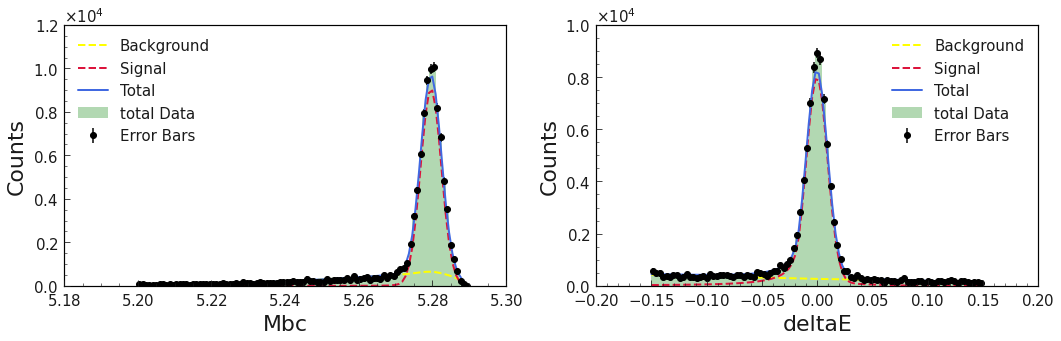

In [21]:
def plot_variable(ax, variable, data_only_signal,Bmeson_bkg,Continuum_bkg, weight_signal, weight_Bmeson_bkg,weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([Bmeson_bkg[variable],Continuum_bkg[variable]])
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = weight_signal
    bkg_weight = pd.concat([weight_Bmeson_bkg,weight_Continuum_bkg])
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.29, 100)
        x_fit = np.linspace(5.20, 5.29, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    
    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green',alpha=0.3,label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight ) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="yellow", linewidth=2)
    
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Counts')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_mu_signal,mc_mu_Bmeson_bkg,mc_mu_Continuum_bkg, mc_mu_signal_weight, mc_mu_Bmeson_bkg_weight,mc_mu_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_mu_signal,mc_mu_Bmeson_bkg,mc_mu_Continuum_bkg, mc_mu_signal_weight, mc_mu_Bmeson_bkg_weight,mc_mu_Continuum_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('q2regs_1 for muctron.png')
plt.show()

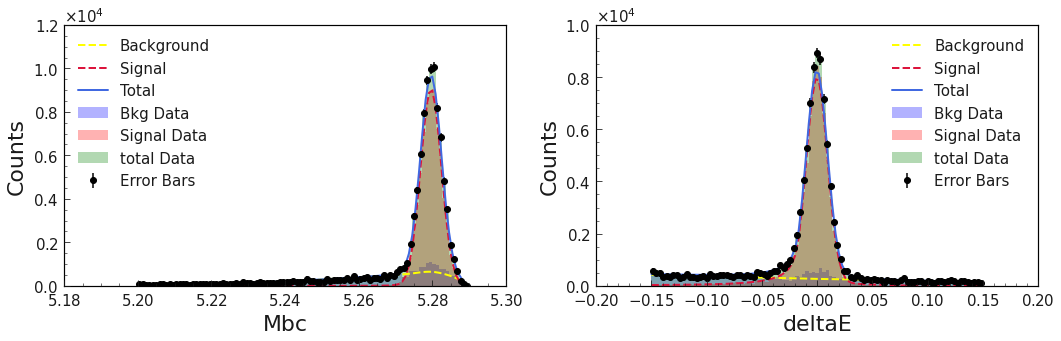

In [22]:
def plot_variable(ax, variable, data_only_signal,Bmeson_bkg,Continuum_bkg, weight_signal, weight_Bmeson_bkg,weight_Continuum_bkg, 
                  signal_pdf, background_pdf, label_signal, label_background):    

    signal_df = pd.concat([data_only_signal[variable]])
    bkg_df = pd.concat([Bmeson_bkg[variable],Continuum_bkg[variable]])
    
    df_total = pd.concat([signal_df,bkg_df])
    
    signal_weight = weight_signal
    bkg_weight = pd.concat([weight_Bmeson_bkg,weight_Continuum_bkg])
    
    total_weight=pd.concat([signal_weight, bkg_weight])
    
    r = np.round(np.random.rand(), decimals=4)


    # Define bin edges and x_fit
    if variable == "Mbc":
        bin_edges = np.linspace(5.20, 5.29, 100)
        x_fit = np.linspace(5.20, 5.29, 100)
    elif variable == "deltaE":
        bin_edges = np.linspace(-0.15, 0.15, 100)
        x_fit = np.linspace(-0.15, 0.15, 100)

    # Plot the background component
    ax.hist(bkg_df, bins=bin_edges, weights= bkg_weight, density=False, color='blue', alpha=0.3, label=label_background)
    y_background_fit = background_pdf.pdf(x_fit) * sum(bkg_weight ) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_background_fit, label="Background", linestyle="--", color="yellow", linewidth=2)

    # Plot the signal component
    ax.hist(signal_df, bins=bin_edges, weights=signal_weight, density=False, color='red',alpha=0.3,label=label_signal)
    y_signal_fit = signal_pdf.pdf(x_fit) * sum(signal_weight) * np.diff(bin_edges)[0]
    ax.plot(x_fit, y_signal_fit, label="Signal", linestyle="--", color="crimson", linewidth=2)

    # Plot the total fit
    n, bins, _ = ax.hist(df_total, bins=bin_edges, weights=total_weight, density=False, color='green',alpha=0.3,label="total Data")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate errors
    bin_weights = []
    for i in range(len(bins) - 1):
        bin_indices = np.where((df_total >= bins[i]) & (df_total < bins[i+1]))[0]
        bin_weights.append(total_weight.iloc[bin_indices].tolist())
    errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]

    # Plot histogram with error bars and fitted model
    ax.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')

    # Plot the total fit with error bars
    y_total_fit = y_signal_fit + y_background_fit 
    ax.plot(x_fit, y_total_fit, label="Total", color="royalblue", linewidth=2)

    # Add labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Counts')
    ax.set_title('')
    ax.legend()

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mbc
plot_variable(axs[0], "Mbc", mc_mu_signal,mc_mu_Bmeson_bkg,mc_mu_Continuum_bkg, mc_mu_signal_weight, mc_mu_Bmeson_bkg_weight,mc_mu_Continuum_bkg_weight, 
              Mbc_signal_pdf, Mbc_background_pdf, "Signal Data", "Bkg Data")

# Plot deltaE
plot_variable(axs[1], "deltaE", mc_mu_signal,mc_mu_Bmeson_bkg,mc_mu_Continuum_bkg, mc_mu_signal_weight, mc_mu_Bmeson_bkg_weight,mc_mu_Continuum_bkg_weight, 
              deltaE_signal_pdf, deltaE_background_pdf, "Signal Data", "Bkg Data")
# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('q2regs_1 for muctron.png')
plt.show()

## Braching ratio ##

In [24]:
from uncertainties import ufloat

cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns


N_bb_mesons=cross_section_nb * (4*luminosity_nb)

print(N_bb_mesons)

N_signal_yield = ufloat(74093.61, 290)
B_JPsi_to_mumu = ufloat(5.961, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_mumu*B_K_to_K_pi)

BR_PDG = ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:", BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:", BR_PDG)


787786560.0
B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight: 0.001186+/-0.000008
B _to_JPsi_and_K*_Branching_ratio_from_PDG: 0.00127+/-0.00005


In [25]:
from uncertainties import ufloat

cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns


N_bb_mesons=cross_section_nb * (4*luminosity_nb)

print(N_bb_mesons)

N_signal_yield = 70299.479
B_JPsi_to_mumu = ufloat(5.961, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_mumu*B_K_to_K_pi)

BR_PDG = ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:", BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:", BR_PDG)


787786560.0
B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight: 0.001126+/-0.000006
B _to_JPsi_and_K*_Branching_ratio_from_PDG: 0.00127+/-0.00005
